DAG Graph

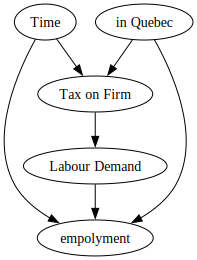

In [43]:
from graphviz import Digraph
g = Digraph()
#g.edge("Tax on Firm","cost of firm")
#g.edge("cost of firm","Labour Demand")
g.edge("Tax on Firm","Labour Demand")
#g.edge("Labour Demand","Income of Labor")
g.edge("Labour Demand","empolyment")
g.edge("Time","Tax on Firm")
#g.edge("time","Income of Labor")
g.edge("Time","empolyment")
g.edge("in Quebec","Tax on Firm")
#g.edge("in Quebec","Income of Labor")
g.edge("in Quebec","empolyment")

g

import libararies

In [44]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

Functions

In [93]:

# a function that performs data cleaning to df, a Pandas dataframe with uncleaned data
# the data type of the variable col is changed to int if num_decimals == 0, 
#     or float (round to num_decimals if num_decimals > 0)
def clean_data(df, col, num_decimals):
  # fill all missing values based on the most previously available value of the column
  # eg: in the raw data, many rows under variables province and sector are empty 
  #     - we fill these cells with the value the most previously non-empty cell
  df = df.fillna(method='ffill')

  # change the data type of the column year to int
  df['year'] = df['year'].astype(np.float32).astype(int)

  # create copies of the column year, call them theta_year, beta_year and gamma_year
  # to calculate the coefficients in the validation model (see Equation (1))
  df['theta_year'] = df['year']
  df['beta_year'] = df['year']
  df['gamma_year'] = df['year']
  
  # change the data type of the input column col to int or float based on num_decimals
  df[col] = df[col].replace({',': ''}, regex=True)
  df[col] = df[col].astype(np.float32)
  if num_decimals == 0:
    df[col] = df[col].astype(int)
  else:
    df[col] = df[col].round(num_decimals)

  # get the log value of column col
  log_var = 'log_' + col
  df[log_var] = np.log(df[col])
  
  # generate dummy variables for province, sector and year variables
  # is_quebec = 1 if it is in Quebec, 0 otherwise
  # is_manu = 1 if it is in manufacturing sector, 0 otherwise
  # is_after_reform = 1 if the year is >= 2014, 0 otherwise
  df['is_quebec'] = (df['province'] == 'Quebec')
  df['is_manu'] = (df['sector'] == 'Manufacturing')
  df['is_after_reform'] = (df['year'] >= 2014)
  df = df.astype({'is_quebec': int, 'is_manu': int, 'is_after_reform': int})

  # generate province-and-sector dummy variable is_manu_quebec, 
  # where it is 1 if it is both manufacturing and in Quebec, 0 otherwise
  df['is_manu_quebec'] = df['is_manu'] * df['is_quebec']

  # generate variable province_sector which joins province and sector together
  # df['province_sector'] = df.apply(lambda x: ' & '.join([x['province'], x['sector']]), axis=1)

  return df
     


In [94]:

# get the table of coefficients theta_tau's in Equation (1) based on df, the summary table of regression
def validation_coef(summary):
  df_coef = pd.read_html(summary.tables[1].as_html(), header=0)[0]
  df_coef = df_coef.iloc[1:8]
  df_coef = df_coef.rename(columns={'Unnamed: 0': 'year'})
  df_coef['year'] = df_coef['year'].str[14:18]
  df_coef['year'] = df_coef['year'].astype(float).astype(int)

  # calculate coef_norm, normalized coefficients, where the 2013 coefficient is normalized to 0
  df_coef['coef_norm'] = df_coef['coef'] - float(df_coef['coef'].loc[df_coef['year'] == 2013])

  # get difference between coefficient and 2.5% confidence interval 
  # and difference between coefficient and 97.5% confidence interval
  # to be plotted as error bar in the triple difference validation graph (as shown in Equation (1))
  df_coef['loerr'] = df_coef['coef'] - df_coef['[0.025']
  df_coef['uperr'] = df_coef['0.975]'] - df_coef['coef']

  return df_coef

In [95]:
# a function that plots the coefficients of each year in parallel trend validation, as shown in Equation (1)
def plot_graph(df):
  plt.figure(figsize=(8,4))

  # plot horizontal reference line y = 0 and time-series reference line x = 2013.5
  plt.axhline(0, color='black')
  plt.axvline(2013.5, color='red')
  
  # plot line graph of coefficients for each year and error bars,
  # where error bars represent the 2.5% confidence interval to 97.5% confidence interval range
  plt.errorbar(x=df['year'], y=df['coef_norm'], 
              yerr=np.array(df[['loerr','uperr']].T), 
              fmt='-o', capsize=5)
  plt.xlabel('Year')
  plt.ylabel('Coefficient Estimates [2013=0]')
  plt.show()
     

In [96]:
emp_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/employment.csv'

# load employment data to a dataframe (top and bottom meaningless rows are removed)
df_emp_monthly = pd.read_csv(emp_url, skiprows=11, skipfooter=18, header=None, engine='python')
df_emp_monthly = df_emp_monthly.rename(columns={0: 'province', 1: 'sector', 2: 'monthyear', 3: 'employment'})
df_emp_monthly
# extract year value from monthyear
df_emp_monthly['year'] = df_emp_monthly['monthyear'].str[-4:]
# clean data using pre-defined clean_data() function
df_emp_monthly = clean_data(df_emp_monthly, 'employment', 0)
# Since the employment is monthly data, for each sector and province combination, calculate its mean employment over each year
# to get an estimate of the acutal annual employment per sector-province combination
df_emp = df_emp_monthly.groupby(['year', 'theta_year', 'beta_year', 'gamma_year', 
                                 'province', 'sector', 'is_quebec', 'is_manu', 
                                 'is_manu_quebec', 'is_after_reform']).mean('employment').reset_index()
df_emp['employment'] = df_emp['employment'].astype(int)

# compute Log(employment)
df_emp['log_employment'] = np.log(df_emp['employment'])

df_emp

,year,theta_year,beta_year,gamma_year,province,sector,is_quebec,is_manu,is_manu_quebec,is_after_reform,employment,log_employment
0,2011,2011,2011,2011,Ontario,Construction,0,0,0,0,281774,12.548861
1,2011,2011,2011,2011,Ontario,Manufacturing,0,1,0,0,654746,13.392003
2,2011,2011,2011,2011,Quebec,Construction,1,0,0,0,178295,12.091195
3,2011,2011,2011,2011,Quebec,Manufacturing,1,1,1,0,419194,12.946089
4,2012,2012,2012,2012,Ontario,Construction,0,0,0,0,291414,12.582500
5,2012,2012,2012,2012,Ontario,Manufacturing,0,1,0,0,663483,13.405259
6,2012,2012,2012,2012,Quebec,Construction,1,0,0,0,186857,12.138099
7,2012,2012,2012,2012,Quebec,Manufacturing,1,1,1,0,417350,12.941680
8,2013,2013,2013,2013,Ontario,Construction,0,0,0,0,296760,12.600679
9,2013,2013,2013,2013,Ontario,Manufacturing,0,1,0,0,660570,13.400858


OLS model

In [97]:

# perform regression based on Equation (1) in the paper
validation_emp = smf.ols(formula='log_employment ~ C(theta_year):is_manu:is_quebec + C(beta_year):is_manu \
                                  + C(gamma_year):is_quebec + is_manu + is_quebec + is_manu_quebec',
                 data=df_emp).fit()
validation_emp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_employment   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     64.05
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           2.13e-05
Time:                        14:31:23   Log-Likelihood:                 57.517
No. Observations:                  28   AIC:                            -71.03
Df Residuals:                       6   BIC:                            -41.73
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                12.6383      0.025    498.985      0.000      12.576      12.700
C(theta_year)[2011]:is_manu:is_quebec     0.0648      0.108      0.602      0.569      -0.199       0.328
C(theta_year)[2012]:is_manu:is_quebec     0.0002      0.108      0.002      0.998      -0.263       0.264
C(theta_year)[2013]:is_manu:is_quebec    -0.0188      0.108     -0.175      0.867      -0.282       0.245
C(theta_year)[2014]:is_manu:is_quebec    -0.0233      0.108     -0.217      0.836      -0.287       0.240
C(theta_year)[2015]:is_manu:is_quebec     0.0135      0.108      0.125      0.904      -0.250       0.277
C(theta_year)[2016]:is_manu:is_quebec     0.0031      0.108      0.029      0.978      -0.260       0.266
C(theta_year)[2017]:is_manu:is_quebec    -0.0032      0.108     -0.030      0.977      -0.267       0.260
is_manu                                   0.7537      0.072     10.521      0.000       0.578       0.929
C(beta_year)[T.2012]:is_manu              0.0133      0.095      0.140      0.893      -0.219       0.245
C(beta_year)[T.2013]:is_manu              0.0089      0.095      0.093      0.929      -0.223       0.241
C(beta_year)[T.2014]:is_manu              0.0024      0.095      0.026      0.980      -0.229       0.234
C(beta_year)[T.2015]:is_manu              0.0121      0.095      0.128      0.902      -0.220       0.244
C(beta_year)[T.2016]:is_manu              0.0096      0.095      0.101      0.923      -0.222       0.241
C(beta_year)[T.2017]:is_manu              0.0233      0.095      0.246      0.814      -0.209       0.255
is_quebec                                -0.5471      0.072     -7.637      0.000      -0.722      -0.372
C(gamma_year)[T.2012]:is_quebec           0.0469      0.095      0.495      0.638      -0.185       0.279
C(gamma_year)[T.2013]:is_quebec           0.0487      0.095      0.514      0.626      -0.183       0.281
C(gamma_year)[T.2014]:is_quebec           0.0448      0.095      0.473      0.653      -0.187       0.277
C(gamma_year)[T.2015]:is_quebec           0.0040      0.095      0.042      0.968      -0.228       0.236
C(gamma_year)[T.2016]:is_quebec           0.0215      0.095      0.227      0.828      -0.210       0.253
C(gamma_year)[T.2017]:is_quebec           0.0432      0.095      0.456      0.664      -0.189       0.275
is_manu_quebec                            0.0364      0.044      0.821      0.443      -0.072       0.145
==============================================================================
Omnibus:                       10.039   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               19.881
Skew:                           0.310   Prob(JB):                     4.82e-05
Kurtosis:  

In [98]:

year_coef_emp = validation_coef(validation_emp.summary())
year_coef_emp

,year,coef,std err,t,P>|t|,[0.025,0.975],coef_norm,loerr,uperr
1,2011,0.0648,0.108,0.602,0.569,-0.199,0.328,0.0836,0.2638,0.2632
2,2012,0.0002,0.108,0.002,0.998,-0.263,0.264,0.0190,0.2632,0.2638
3,2013,-0.0188,0.108,-0.175,0.867,-0.282,0.245,0.0000,0.2632,0.2638
4,2014,-0.0233,0.108,-0.217,0.836,-0.287,0.240,-0.0045,0.2637,0.2633
5,2015,0.0135,0.108,0.125,0.904,-0.250,0.277,0.0323,0.2635,0.2635
6,2016,0.0031,0.108,0.029,0.978,-0.260,0.266,0.0219,0.2631,0.2629
7,2017,-0.0032,0.108,-0.030,0.977,-0.267,0.260,0.0156,0.2638,0.2632


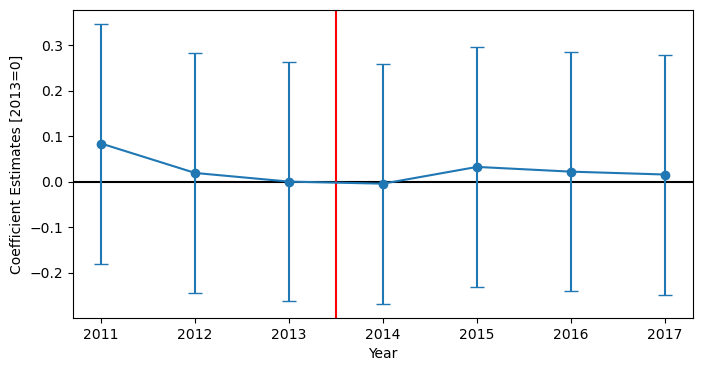

In [99]:

# Plot coefficient for each year with the confidence interval
plot_graph(year_coef_emp)